In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
import matplotlib 
import astropy.units as u
from astropy.io import fits
from astropy.constants import m_p, M_sun

import os
gd_folder = os.getcwd()+"/../../Calculations/SKIRTOR/"

import sys 
sys.path.append(gd_folder)
#from loadSKIRTOR_MRN77 import LoadSKIRTOR_MRN77
from loadSKIRTOR_MRN77_force_reg import LoadSKIRTOR_MRN77
from loadSKIRTOR_General import LoadSKIRTOR_General

sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
general_method_interp = "linear"
#general_method_interp = "pchip"

In [3]:
#Set the object ID.
wid = "W0204-0506"

In [4]:
#Load the object properties.
op = ObjectProperties([wid])

In [5]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [6]:
#Read the MRN77 chi2 map. 
p_map = dict()
chi2_map = dict()
pws = dict()
cone_types = ["Top", "Bottom", "Full"]
for cone_type in cone_types:
    pws[cone_type] = LoadSKIRTOR_MRN77(cone_type=cone_type, interp_method=general_method_interp, get_scatt_frac=True)

pws_linear = dict()
for cone_type in cone_types:
    pws_linear[cone_type] = LoadSKIRTOR_MRN77(cone_type=cone_type, interp_method='linear')

bands_use = list()
p_meas = list()
p_unc = list()
for band in op.pfrac[wid].keys():
    bands_use.append(bands.bp[band])
    p_meas.append(op.pfrac[wid][band])
    p_unc.append(op.epfrac[wid][band])

chi2_map[wid] = dict()
for cone_type in cone_types:
    if cone_type=="Full":
        fname = "../SKIRTOR_fit/maps/chi2_map_{}.fits".format(wid)
    else:
        fname = "maps_{}Cone/chi2_map_{}.fits".format(cone_type, wid)
    h = fits.open(fname)
    tang_grid = np.array(h[0].header['TANGGRID'].split()).astype(float)
    tang_grid = tang_grid * u.Unit(h[0].header['TANGUNIT'])
    cang_grid = np.array(h[0].header['CANGGRID'].split()).astype(float)
    cang_grid = cang_grid * u.Unit(h[0].header['CANGUNIT'])
    iang_grid = np.array(h[0].header['IANGGRID'].split()).astype(float)
    iang_grid = iang_grid * u.Unit(h[0].header['IANGUNIT'])
    chi2_map[wid][cone_type] = np.ma.zeros((len(tang_grid), len(cang_grid), len(iang_grid)))
    chi2_map[wid][cone_type][:,:,:] = h[0].data
    chi2_map[wid][cone_type].mask = h[1].data.astype(bool)


In [7]:
#Make a quick plot comparing linear and pchip interpolation. 
lam_grid = np.arange(1200., 3000., 20.)*u.AA

Top 32.5 deg 21.0 deg 56.0 deg 7.689583731337499e-10
0.38104231982254677 0.4096434750646818
Bottom 50.0 deg 35.5 deg 61.0 deg 1.4407787221813311e-08
0.7075231711028809 0.7437430074526439
Full 28.0 deg 15.0 deg 48.5 deg 3.83571358380841e-08
0.37487984537903707 0.3977350634281577


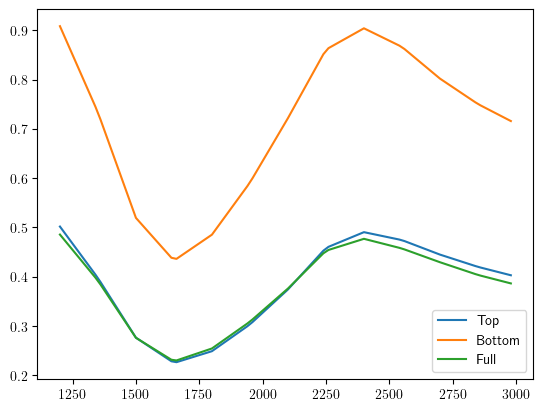

In [8]:
#Find the best solution for W0204-0506
for cone_type in cone_types:
    i, j, k = np.unravel_index(np.argmin(chi2_map[wid][cone_type], axis=None), chi2_map[wid][cone_type].shape)
    print(cone_type, tang_grid[i], cang_grid[j], iang_grid[k], chi2_map[wid][cone_type].min())
    scatt_frac = 100.*pws['Full'].scatt_frac((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid))
    plt.plot(lam_grid, scatt_frac, label=cone_type)
    print(np.mean(scatt_frac),np.median(scatt_frac))
plt.legend()

In [9]:
mean_scatt_frac_top = pws['Top'].mean_scatt_frac(tang_grid, cang_grid, iang_grid)
mean_scatt_frac_bot = pws['Bottom'].mean_scatt_frac(tang_grid, cang_grid, iang_grid)

In [10]:
mean_scatt_frac_bot.shape

(71, 91, 131)

In [11]:
diang = np.mean(iang_grid[1:]-iang_grid[:-1]).value
iang_grid_extended = np.arange(-90., 90.1, diang)*u.deg
nie = len(iang_grid_extended) 
nt, nc, ni = chi2_map[wid][cone_types[0]].shape

chi2_use = np.ma.zeros((nt, nc, nie))
chi2_use.mask = np.zeros(chi2_use.shape, dtype=bool)

chi2_use[:,:,:ni] = np.copy(chi2_map[wid][cone_types[1]][:,:,::-1])
chi2_use[:,:,nie-ni:] = np.copy(chi2_map[wid][cone_types[0]])
chi2_use.mask[:,:,ni:nie-ni] = True
vmin = np.min(chi2_use)
vmax = 5.0 #3.0

mean_scatt_frac = np.zeros((nt, nc, nie))
mean_scatt_frac[:,:,:ni] = np.copy(mean_scatt_frac_bot[:,:,::-1])
mean_scatt_frac[:,:,nie-ni:] = np.copy(mean_scatt_frac_top)

II, JJ, KK = np.meshgrid(tang_grid.value, cang_grid.value+10, iang_grid_extended.value, indexing='ij')

chi2_use.mask[(JJ>II) | (np.abs(KK)<II)] = True
chi2_use.mask[chi2_use>vmax] = True

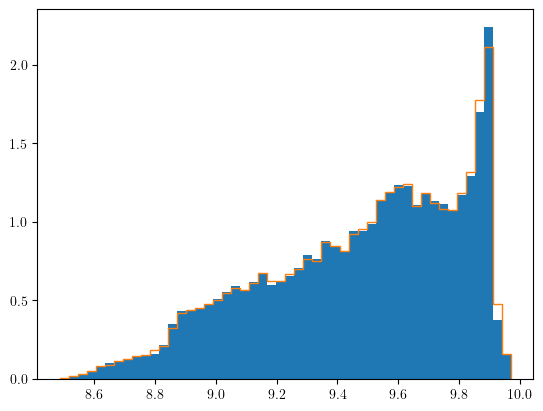

[5.96213928e+08 1.26006699e+09 3.46090398e+09 6.82468660e+09
 8.08185666e+09]
[0.00534677 0.00820327 0.0122316  0.02038023 0.03670754]


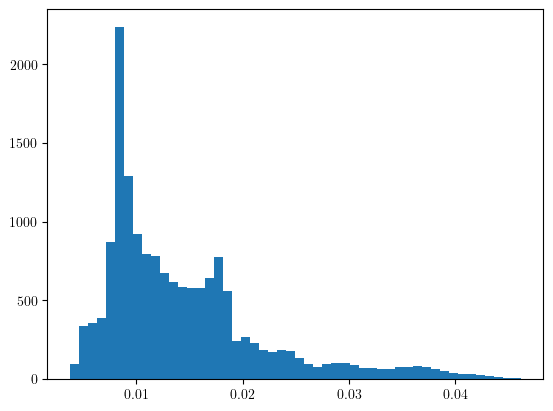

In [26]:
#We'll get the gas mass for every allowed combination of parameters, and then weigh each pf them by the likelihood and add the weighted numbers to get the distribution. 

tau_V = 0.1 * 0.013/mean_scatt_frac
delta_psi_c = 10*u.deg #10*u.deg
psi_c = np.array([10, 38, 40])*u.deg #cang_grid[j]
X = 1.5e-23*u.cm**2
L = 10*u.kpc
Rv = 3.1

Mg = (2.5/np.log(10.)) * np.pi/3. * m_p * tau_V/(X*Rv) * L**2 * np.cos(JJ*u.deg-delta_psi_c/2.)*(np.tan(JJ*u.deg))**2
#print((Mg/M_sun).to(u.dimensionless_unscaled)/1e9)


#plt.hist(tau_V[~chi2_use.mask], bins=50)
binned_lMg_vals, binned_lMg_bin_edges, _ = plt.hist(np.log10(Mg[~chi2_use.mask]/(M_sun)).to(u.dimensionless_unscaled), density=True, bins=50, weights=np.exp(-0.5*chi2_use[~chi2_use.mask]))

plt.hist(np.log10(Mg[~chi2_use.mask]/(M_sun)).to(u.dimensionless_unscaled), density=True, bins=50, histtype='step')#, weights=np.exp(-0.5*chi2_use[~chi2_use.mask]))
plt.show()

#Now the obscuration of a light ray going through the dusty section of the cone at mid-height
d = 0.5*L*(np.tan(JJ*u.deg)-np.tan(JJ*u.deg-delta_psi_c))
n_H = (2.5/np.log(10.)) * tau_V/(X*Rv) * np.cos(JJ*u.deg-delta_psi_c/2.)/L
ebv = X*n_H*d
binned_ebv_vals, binned_ebv_bin_edges, _ = plt.hist(ebv[~chi2_use.mask], bins=50, weights=np.exp(-0.5*chi2_use[~chi2_use.mask]))

print(np.percentile((Mg[~chi2_use.mask]/M_sun).to(u.dimensionless_unscaled), [2.3, 15.85, 50., 84.15, 97.7]))
print(np.percentile(ebv[~chi2_use.mask], [2.3, 15.85, 50., 84.15, 97.7]))
#print(np.exp(-0.5*chi2_use[~chi2_use.mask]))

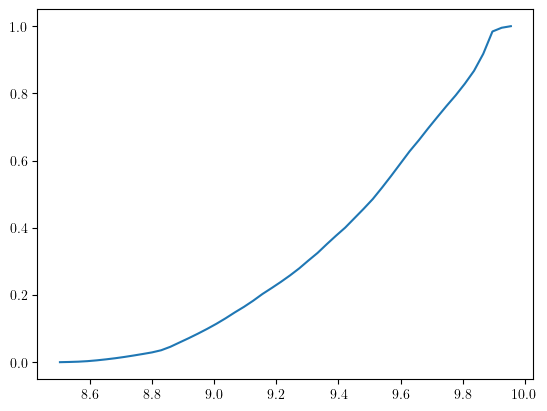

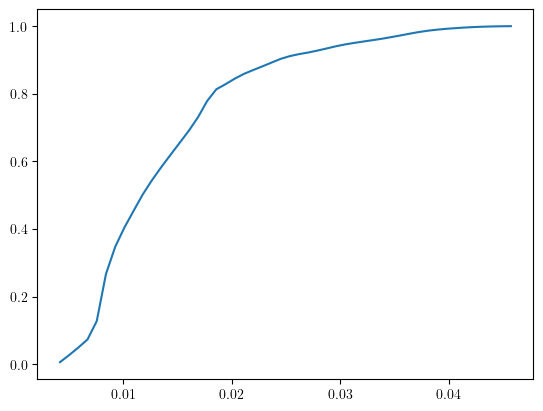

In [27]:
lMg_cumulative = np.cumsum(binned_lMg_vals)/np.sum(binned_lMg_vals)
lMg_bin_centers = 0.5*(binned_lMg_bin_edges[1:] + binned_lMg_bin_edges[:-1])
plt.plot(lMg_bin_centers, lMg_cumulative)
plt.show()

ebv_cumulative = np.cumsum(binned_ebv_vals)/np.sum(binned_ebv_vals)
ebv_bin_centers = 0.5*(binned_ebv_bin_edges[1:] + binned_ebv_bin_edges[:-1])
plt.plot(ebv_bin_centers, ebv_cumulative)
plt.show()

In [32]:
print(np.interp([2.3, 15.85, 50., 84.15, 97.7], lMg_cumulative*100, lMg_bin_centers))
print(np.interp([2.3, 15.85, 50., 84.15, 97.7], ebv_cumulative*100, ebv_bin_centers))

[8.75984175 9.08448335 9.52327477 9.81691148 9.89287486]
[0.00488926 0.00778183 0.01178931 0.02012863 0.03626983]


In [29]:
def get_errors(binned_values, bin_edges):

    vals_cumulative = np.cumsum(binned_values)/np.sum(binned_values)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

    ps = np.interp([2.3, 15.85, 50., 84.15, 97.7], vals_cumulative*100, bin_centers)
    return ps[2], ps[2]-ps[1], ps[3]-ps[2], ps[2]-ps[0], ps[4]-ps[0]



In [33]:
print(get_errors(binned_lMg_vals, binned_lMg_bin_edges))
print(get_errors(binned_ebv_vals, binned_ebv_bin_edges))

(9.52327477451579, 0.4387914236419448, 0.293636702853286, 0.7634330213701741, 1.1330331037378603)
(0.011789309167729545, 0.004007477872979901, 0.00833931679476243, 0.006900050306845039, 0.031380573480174284)
